<a href="https://colab.research.google.com/github/Beh-noush/General-Python/blob/main/titanic_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pytorch Example: Titanic Dataset

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

seed = 1234
np.random.seed(seed) # Set the random seed of numpy for the data split.

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")


print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.10.0+cu111
GPU Available: True


##Titanic Dataset

##Preprocessing

In [2]:
titanic_preprocess_df = pd.read_csv(
    'https://github.com/afansi/winterschool18/blob/master/titanic_prepocess.csv?raw=true', 
    sep=',', 
    index_col=None
)

titanic_preprocess_df.head()

,survived,pclass_1,pclass_2,pclass_3,sex_female,sex_male,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,0,1,0,29.0000,0,0,211.3375,0,0,1
1,1,1,0,0,0,1,0.9167,1,2,151.5500,0,0,1
2,0,1,0,0,1,0,2.0000,1,2,151.5500,0,0,1
3,0,1,0,0,0,1,30.0000,1,2,151.5500,0,0,1
4,0,1,0,0,1,0,25.0000,1,2,151.5500,0,0,1


##Train / validation / test split

In [3]:
train, validate, test = np.split(
    titanic_preprocess_df.sample(frac=1, random_state=seed), 
    [int(.6*len(titanic_preprocess_df)), int(.8*len(titanic_preprocess_df))])

# Remove the label column from X and create a label vectors.
X_train = train.drop(['survived'], axis=1).values
y_train = train['survived'].values

X_val = validate.drop(['survived'], axis = 1).values # To complete.
y_val = validate['survived'].values # To complete.

X_test = test.drop(['survived'], axis=1).values # To complete.
y_test = test['survived'].values # To complete.


#Datasets in PyTorch

In [4]:
#to manipulate together the features and targets of a dataset.
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long()) # To complete.

test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()) # To complete.


##How to define a model in PyTorch?

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [42]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(12, 20)
        self.fc2 = nn.Linear(20,40)
        self.fc3 = nn.Linear(40,20)
        self.out = nn.Linear(20,2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = F.softmax(self.out(x),dim = 1)
        #output = self.out(x)
        return output

In [39]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(12, 20)
        self.fc2 = nn.Linear(20,40)
        self.fc3 = nn.Linear(40,20)
        self.out = nn.Linear(20,2)
    def forward(self, x):
        x = torch.nn.ReLU(self.fc1(x))
        x = torch.nn.ReLU(self.fc2(x))
        x = torch.nn.ReLU(self.fc3(x))
        output = torch.nn.Softmax(self.out(x),dim = 1)
        #output = self.out(x)
        return output

#Making predictions with our neural network!

In [36]:
#Loss function
import torch.nn.functional as F
def model_loss(output,target):
  return F.cross_entropy(output,target)

In [8]:
#model accuracy
def model_accuracy(prediction,target):
  return torch.mean((prediction == target).float())

##Back Propagation and Optimization

In [9]:
import torch.optim as optim

#Train a model

##Creat mini-batches of length 32 each

In [10]:
train_batch_size = 32  # number of data in a training batch.
eval_batch_size = 32   # number of data in an batch.


In [11]:
import torch.utils.data.dataloader as loader

In [12]:
train_loaded = torch.utils.data.DataLoader(train_dataset,train_batch_size,shuffle=True)

In [13]:
from tqdm import tqdm

In [44]:
num_loads = len(train_loaded)
neural_net = NeuralNet()
#neural_net.to(device) Why does not this work for cuda?!
neural_net.cuda
neural_net.eval()
lr = .0001

model_optimizer = optim.Adam(neural_net.parameters(),lr = lr)
#model_optimizer = optim.RMSprop(neural_net.parameters(), lr= lr)
num_epochs = 8000
acc_epoch = []
loss_epoch = []

for e in tqdm(range(num_epochs)):
  loss = 0
  acc = 0
  for input,label in iter(train_loaded):
    input.to(device)
    label.to(device)
    model_output = neural_net(input)
    _, model_pred = torch.max(model_output,axis = 1)
    batch_loss = model_loss(model_output, label)/num_loads
    loss += batch_loss
    batch_acc = model_accuracy(model_pred, label)/num_loads
    acc += batch_acc
    batch_loss.backward()
    model_optimizer.step()
    model_optimizer.zero_grad()
    #print(batch_acc)
  if e%100==0:
    acc_epoch.append(acc)
    loss_epoch.append(loss)

100%|██████████| 8000/8000 [04:26<00:00, 30.02it/s]


In [45]:
import matplotlib.pyplot as plt

In [46]:
def plot_training(loss_epoch, acc_epoch, lr, optimizer):
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.plot(loss_epoch)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.subplot(1,2,2)
  plt.plot(acc_epoch)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title(f'lr = {lr}, optimizer = {optimizer}')

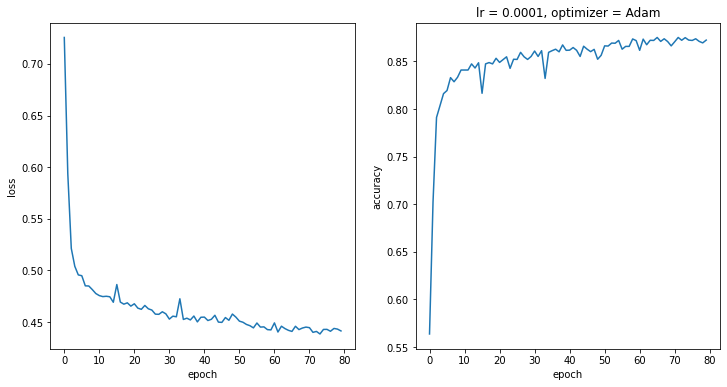

In [47]:
plot_training(loss_epoch, acc_epoch, lr, 'Adam')

In [48]:
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=train_batch_size)

In [60]:
#The whole train-validation model :
num_loads_train = len(train_loaded)
num_loads_valid = len(valid_loader)

neural_net = NeuralNet()
#neural_net.to(device)    Question : why this command instead of neural_net.cuda results in that error of devices???
neural_net.cuda
#neural_net.train()
lr = .0001

model_optimizer = optim.Adam(neural_net.parameters(),lr = lr)
#model_optimizer = optim.RMSprop(neural_net.parameters(), lr= lr)
num_epochs = 4000
train_acc_epoch = []
train_loss_epoch = []
test_acc_epoch = []
test_loss_epoch = []

for e in tqdm(range(num_epochs)):
  loss_train = 0
  acc_train = 0
  for input,label in iter(train_loaded):
    input.to(device)
    label.to(device)
    model_output = neural_net(input)
    _, model_pred = torch.max(model_output,axis = 1)
    batch_loss_train = model_loss(model_output, label)/num_loads_train
    loss_train += batch_loss_train
    batch_acc_train = model_accuracy(model_pred, label)/num_loads_train
    acc_train += batch_acc_train
    batch_loss_train.backward()
    model_optimizer.step()
    model_optimizer.zero_grad()
    #print(batch_acc)
  acc_test=0
  loss_test=0
 # num_loads = len(val_dataset)/train_batch_size
  for (val_data,label) in iter(valid_loader):
    val_data.to(device)
    label.to(device)
    model_output = neural_net(val_data)
    _,model_pred = torch.max(model_output, axis =1)
    batch_acc_test = model_accuracy(model_pred, label)/num_loads_valid
    acc_test += batch_acc_test
    with torch.no_grad():
      batch_loss_test = model_loss(model_output, label)/num_loads_valid
      loss_test += batch_loss_test
  if e%100==0:
    train_acc_epoch.append(acc_train)
    train_loss_epoch.append(loss_train)
    test_acc_epoch.append(acc_test)
    test_loss_epoch.append(loss_test)
  

100%|██████████| 4000/4000 [02:32<00:00, 26.31it/s]


##Question : why the command "neural_net.to(device)" instead of "neural_net.cuda" results in that error of devices???

In [75]:
def plot_training_validation(loss_train, acc_train, loss_test, acc_test, lr, optimizer):
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1,2,1)
  plt.plot(loss_train,'g',label = 'train')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.plot(loss_test,'r', label = 'test')
  plt.grid(True)
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(acc_train, 'g', label = 'train')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.plot(acc_test, 'r', label = 'test')
  plt.grid(True)
  plt.legend()


  plt.title(f'lr = {lr}, optimizer = {optimizer}')

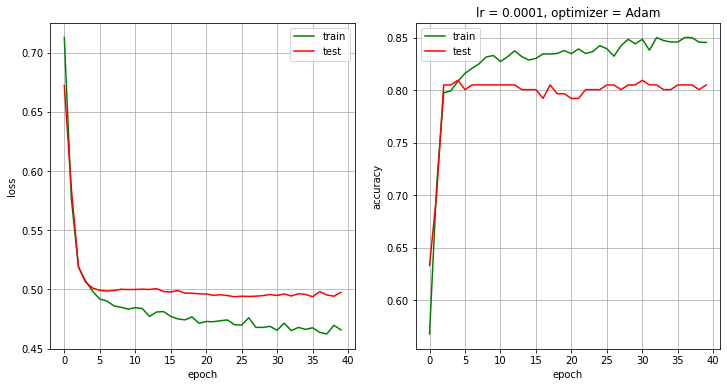

In [76]:
plot_training_validation(train_loss_epoch,train_acc_epoch, test_loss_epoch, test_acc_epoch, lr, 'Adam')

In [55]:
#Don't forget model.train() vs. model.eval()!